In [891]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import warnings
#warnings.filterwarnings('ignore')
pd.set_option("future.no_silent_downcasting", True)

seed = 1234
np.random.seed(seed)  

In [772]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

# Read train data and treat " ?" as Null values
train_df = pd.read_csv("adult/adult.data", names=columns, sep=",", header=None, na_values=[" ?"])

# test data and treat " ?" as Null values
test_df = pd.read_csv("adult/adult.test", names=columns, sep=",", header=None, skiprows=1, na_values=[" ?"])

In [774]:
print(train_df.shape)
train_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [776]:
# print(test_df.shape)
# test_df.head()

In [778]:
# train_df.info();

In [780]:
# Summary statistics for numerical columns
# print(train_df.describe());

In [782]:
# number of missing values in train data
print(train_df.isnull().sum())  

# drop null rows
train_df.dropna(inplace=True)

# number of values in train data after dropping rows
#print(train_df.isnull().sum())  

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64


In [784]:
# number of missing values in test data
print(test_df.isnull().sum())  

# drop null rows
test_df.dropna(inplace=True)

# number of missing values in test data after dropping rows
#print(test_df.isnull().sum())  

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64


## EDA

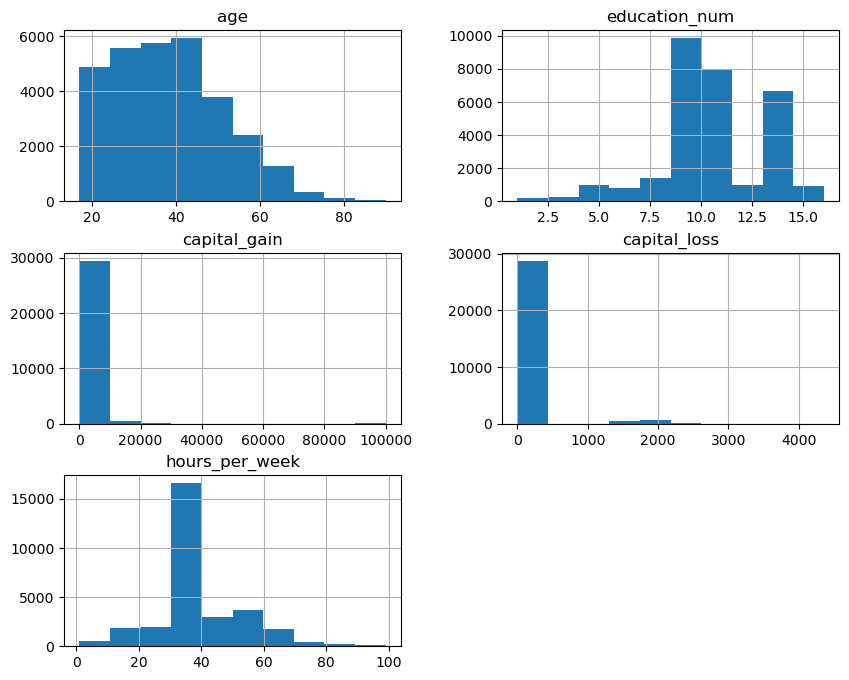

In [816]:
# Histogram
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
train_df[numerical_features].hist(figsize=(10, 8));

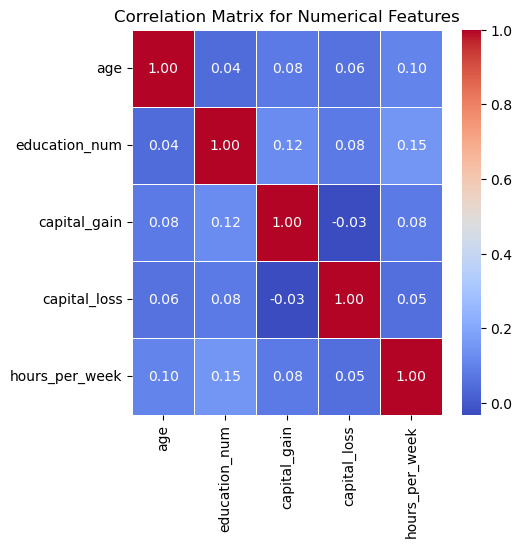

In [897]:
# CORRELATION MATRIX /HEATMAP
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

#  correlation matrix
correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

### Splitting train_df into train & validation sets

In [790]:
#train_df['income'] = train_df['income'].replace({' <=50K': 0, ' >50K': 1})
train_df['income'] = train_df['income'].str.strip()
train_df = train_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# Features
X = train_df.drop(columns=["income"])
# Target labels
y = train_df["income"]  

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

train_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [792]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

(30162, 14)
(27145, 14)
(3017, 14)


In [794]:
# target labels of adult.test end with ".", we remove "."
test_df['income'] = test_df['income'].str.strip().str.replace('.', '')
#test_df['income'] = test_df['income'].replace({' <=50K.': 0, ' >50K.': 1})

test_df = test_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

X_test = test_df.drop(columns=['income'])
y_test = test_df['income']

test_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


### converting categorical data to numerical values

In [797]:
#label encoder
# https://medium.com/@kattilaxman4/a-practical-guide-for-python-label-encoding-with-python-fb0b0e7079c5

categorical_features =[ 'workclass',  'education',  'marital_status', 'occupation',
                        'relationship', 'race', 'sex',  'native_country']
## code for label encoder
# for feature in categorical_features: 
#     print("\n", feature)
#     label_encoder = LabelEncoder()
    
#     print(X_train[feature].unique())
#     X_train[feature]= label_encoder.fit_transform(X_train[feature])
#     print(X_train[feature].unique())
    
#     X_val[feature] = label_encoder.transform(X_val[feature])
#     X_test[feature]= label_encoder.transform(X_test[feature])

# code for pd dummies 
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_val = pd.get_dummies(X_val, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# encoding target labels 
label_encoder = LabelEncoder()
# Fit the encoder on the target variable
y_train = label_encoder.fit_transform(y_train)  # Training target variable
y_val = label_encoder.transform(y_val)          # Validation target variable
y_test= label_encoder.transform(y_test)        # Test target variable



In [799]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

#X_train

(30162, 14)
(27145, 104)
(3017, 104)


### Feature scaling

In [801]:
# NO FEAUTURE SCALING REQUIRED FOR TREE BASED MODELS
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Random Forest

In [827]:
# BASE model

# learner with default params
learner = RandomForestClassifier(random_state=seed)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.00014735678762202984

validation error rate :  0.13954259197878688

test error rate :  0.15265604249667994


In [805]:
learner?

Type:        RandomForestClassifier
String form: RandomForestClassifier(random_state=1234)
Length:      100
File:        /opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py
Docstring:  
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

For a comparison between tree-based ensemble models see the example
:ref:`sphx_glr_auto_examples_ensemble_plot_forest_hist_grad_boosting_comparison.py`.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=

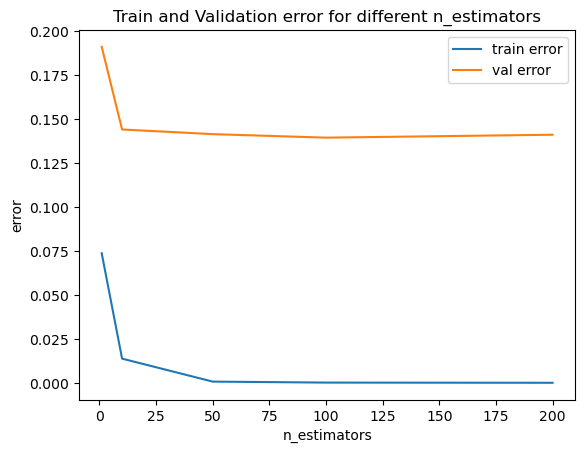

In [811]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200]

train_errors = []
val_errors = []

for n in n_estimators: 

     RF = RandomForestClassifier( 
                     n_estimators=n, # number of trees
                     #max_depth=10,  # Restrict depth
                     #min_samples_split=5,  # Minimum samples required to split
                     random_state=seed)

     RF.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= RF.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate, bootstrap
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Train and Validation error for different n_estimators')
plt.legend()
plt.show()

In [ ]:
# We can see that the fit of the random forest models (given multiple ensemble members) a single tree

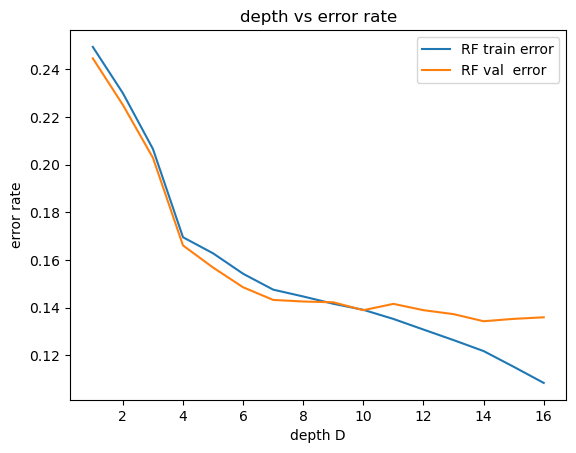

In [818]:
RF_train_err_d = []
RF_val_err_d = []

depth = list(range(1, 17))

for d in depth:
    learner = RandomForestClassifier(
    max_depth=d,  # Restrict depth
    random_state=seed
)
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , RF_train_err_d,  label = 'RF train error');
plt.plot(depth , RF_val_err_d,    label = 'RF val  error');

plt.title("max depth vs error rate");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

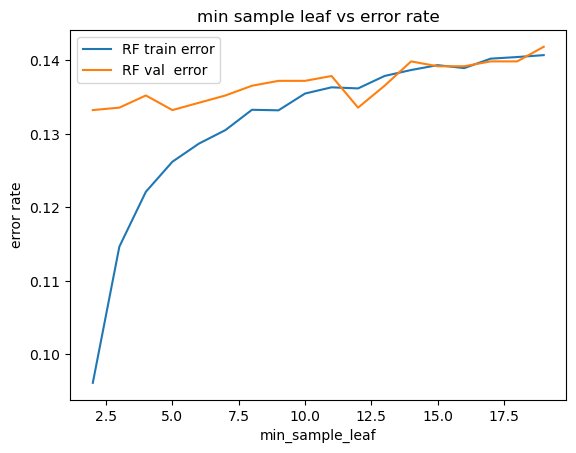

In [863]:
RF_train_err_msl = []
RF_val_err_msl = []
min_sample_leaf =  list(range(2, 20))

# creating values
# for i in range(1,6): 
#     min_sample_leaf.append(2**i)
    
for msl in min_sample_leaf: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_leaf=msl,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_msl.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_msl.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_leaf , RF_train_err_msl,  label = 'RF train error');
plt.plot(min_sample_leaf , RF_val_err_msl,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample leaf vs error rate");
plt.xlabel("min_sample_leaf");
plt.ylabel("error rate");
plt.legend();

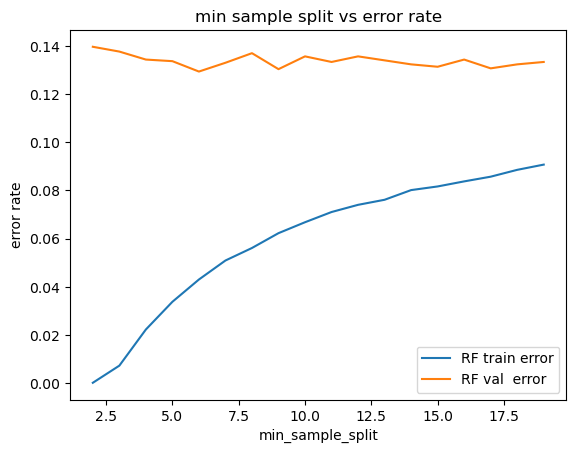

In [865]:
RF_train_err_mss = []
RF_val_err_mss = []
min_sample_split =  list(range(2, 20))
    
for mss in min_sample_split: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_split=mss,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_mss.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_mss.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_split , RF_train_err_mss,  label = 'RF train error');
plt.plot(min_sample_split , RF_val_err_mss,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample split vs error rate");
plt.xlabel("min_sample_split");
plt.ylabel("error rate");
plt.legend();

In [899]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [7,10,14],
    'min_samples_split': [6,9],
    'min_samples_leaf': [5,10,12]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 100}
Best score: 0.8642843986001105


## optimal model

In [903]:

# learner with tuned hyperparameters
learner = RandomForestClassifier(random_state=seed, max_depth= 14, min_samples_leaf=12, min_samples_split = 6, n_estimators = 200)
#learner = RandomForestClassifier(random_state=seed, max_depth= 7, min_samples_leaf=5, min_samples_split = 6, n_estimators = 100)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.14242033523669184

validation error rate :  0.14153132250580047

test error rate :  0.1454183266932271


## Cross Validation

In [ ]:
# perform cross val

## Gradient Boost

In [905]:
# https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
import xgboost as xgb

# Initialize the XGBoost model (this is the sklearn-compatible API)
model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,      # Avoid label encoder warning
    random_state=seed               # For reproducibility
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= model.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= model.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the tes error rates
test_err = (y_test!= model.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.09917111806962609

validation error rate :  0.12131256214782897

test error rate :  0.13140770252324038


In [907]:
model?

Type:        XGBClassifier
String form:
XGBClassifier(base_score=None, booster=None, callbacks=None,
           colsample_bylevel=None <...> ne, n_estimators=None,
           n_jobs=None, num_parallel_tree=None, random_state=1234, ...)
File:        /opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py
Docstring:  
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: